In [1]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode


In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


data_dir = '/home/n/Videos/datasets/hymenoptera_data'
image_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms)
                 
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=4,
                                             shuffle=True, num_workers=0)
             
dataset_sizes = len(image_datasets)
class_names = image_datasets.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


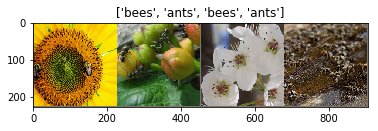

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])



In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
        scheduler.step()
        model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

            # Iterate over data.
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

                # zero the parameter gradients
            optimizer.zero_grad()

                # forward
                # track history if only in train
#             with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
#                     if phase == 'train':
            loss.backward()
            optimizer.step()

                # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                epoch, epoch_loss, epoch_acc))

            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
model_ft = models.vgg16(pretrained=True)
model_ft.classifier = nn.Sequential(
                nn.Dropout(),
                nn.Linear(25088, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Linear(4096, 2),
)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------
0 Loss: 0.0125 Acc: 0.0000
0 Loss: 0.0250 Acc: 0.0000
0 Loss: 0.0366 Acc: 0.0123
0 Loss: 0.0482 Acc: 0.0164
0 Loss: 0.0603 Acc: 0.0205
0 Loss: 0.0718 Acc: 0.0287
0 Loss: 0.0823 Acc: 0.0410
0 Loss: 0.0951 Acc: 0.0492
0 Loss: 0.1029 Acc: 0.0615
0 Loss: 0.1179 Acc: 0.0697
0 Loss: 0.1226 Acc: 0.0861
0 Loss: 0.1459 Acc: 0.0861
0 Loss: 0.1572 Acc: 0.0943
0 Loss: 0.1702 Acc: 0.0943
0 Loss: 0.1776 Acc: 0.1107
0 Loss: 0.1866 Acc: 0.1230
0 Loss: 0.2005 Acc: 0.1311
0 Loss: 0.2112 Acc: 0.1434
0 Loss: 0.2155 Acc: 0.1598
0 Loss: 0.2217 Acc: 0.1721
0 Loss: 0.2312 Acc: 0.1803
0 Loss: 0.2558 Acc: 0.1844
0 Loss: 0.2665 Acc: 0.1926
0 Loss: 0.2762 Acc: 0.2008
0 Loss: 0.2842 Acc: 0.2131
0 Loss: 0.2905 Acc: 0.2295
0 Loss: 0.2965 Acc: 0.2459
0 Loss: 0.3054 Acc: 0.2582
0 Loss: 0.3227 Acc: 0.2664
0 Loss: 0.3313 Acc: 0.2787
0 Loss: 0.3421 Acc: 0.2869
0 Loss: 0.3494 Acc: 0.2992
0 Loss: 0.3571 Acc: 0.3115
0 Loss: 0.3599 Acc: 0.3279
0 Loss: 0.3654 Acc: 0.3402
0 Loss: 0.3718 Acc: 0.3525
0 Loss

4 Loss: 0.3554 Acc: 0.7910
4 Loss: 0.3563 Acc: 0.8074
4 Loss: 0.3616 Acc: 0.8197
4 Loss: 0.3632 Acc: 0.8361
4 Loss: 0.3633 Acc: 0.8525

Epoch 5/24
----------
5 Loss: 0.0015 Acc: 0.0164
5 Loss: 0.0035 Acc: 0.0328
5 Loss: 0.0054 Acc: 0.0492
5 Loss: 0.0062 Acc: 0.0656
5 Loss: 0.0120 Acc: 0.0779
5 Loss: 0.0179 Acc: 0.0902
5 Loss: 0.0206 Acc: 0.1066
5 Loss: 0.0208 Acc: 0.1230
5 Loss: 0.0216 Acc: 0.1393
5 Loss: 0.0227 Acc: 0.1557
5 Loss: 0.0244 Acc: 0.1721
5 Loss: 0.0281 Acc: 0.1885
5 Loss: 0.0307 Acc: 0.2049
5 Loss: 0.0317 Acc: 0.2213
5 Loss: 0.0344 Acc: 0.2377
5 Loss: 0.0346 Acc: 0.2541
5 Loss: 0.0390 Acc: 0.2664
5 Loss: 0.0431 Acc: 0.2828
5 Loss: 0.0439 Acc: 0.2992
5 Loss: 0.0457 Acc: 0.3156
5 Loss: 0.0457 Acc: 0.3320
5 Loss: 0.0681 Acc: 0.3443
5 Loss: 0.0703 Acc: 0.3607
5 Loss: 0.0704 Acc: 0.3770
5 Loss: 0.0705 Acc: 0.3934
5 Loss: 0.0710 Acc: 0.4098
5 Loss: 0.0711 Acc: 0.4262
5 Loss: 0.0714 Acc: 0.4426
5 Loss: 0.0741 Acc: 0.4590
5 Loss: 0.0747 Acc: 0.4754
5 Loss: 0.0747 Acc: 0.4918
5 Los

9 Loss: 0.0678 Acc: 0.8279
9 Loss: 0.0757 Acc: 0.8402
9 Loss: 0.0761 Acc: 0.8566
9 Loss: 0.0761 Acc: 0.8730
9 Loss: 0.0761 Acc: 0.8893
9 Loss: 0.0770 Acc: 0.9057
9 Loss: 0.0828 Acc: 0.9180
9 Loss: 0.0837 Acc: 0.9344
9 Loss: 0.0864 Acc: 0.9508
9 Loss: 0.0885 Acc: 0.9672

Epoch 10/24
----------
10 Loss: 0.0008 Acc: 0.0164
10 Loss: 0.0022 Acc: 0.0328
10 Loss: 0.0037 Acc: 0.0492
10 Loss: 0.0112 Acc: 0.0615
10 Loss: 0.0213 Acc: 0.0738
10 Loss: 0.0220 Acc: 0.0902
10 Loss: 0.0222 Acc: 0.1066
10 Loss: 0.0223 Acc: 0.1230
10 Loss: 0.0225 Acc: 0.1393
10 Loss: 0.0246 Acc: 0.1557
10 Loss: 0.0260 Acc: 0.1721
10 Loss: 0.0265 Acc: 0.1885
10 Loss: 0.0265 Acc: 0.2049
10 Loss: 0.0293 Acc: 0.2213
10 Loss: 0.0297 Acc: 0.2377
10 Loss: 0.0310 Acc: 0.2541
10 Loss: 0.0311 Acc: 0.2705
10 Loss: 0.0354 Acc: 0.2828
10 Loss: 0.0358 Acc: 0.2992
10 Loss: 0.0358 Acc: 0.3156
10 Loss: 0.0360 Acc: 0.3320
10 Loss: 0.0377 Acc: 0.3484
10 Loss: 0.0378 Acc: 0.3648
10 Loss: 0.0407 Acc: 0.3811
10 Loss: 0.0457 Acc: 0.3934
10 Los

14 Loss: 0.0364 Acc: 0.5738
14 Loss: 0.0367 Acc: 0.5902
14 Loss: 0.0368 Acc: 0.6066
14 Loss: 0.0370 Acc: 0.6230
14 Loss: 0.0377 Acc: 0.6393
14 Loss: 0.0378 Acc: 0.6557
14 Loss: 0.0378 Acc: 0.6721
14 Loss: 0.0397 Acc: 0.6885
14 Loss: 0.0399 Acc: 0.7049
14 Loss: 0.0405 Acc: 0.7213
14 Loss: 0.0410 Acc: 0.7377
14 Loss: 0.0411 Acc: 0.7541
14 Loss: 0.0412 Acc: 0.7705
14 Loss: 0.0434 Acc: 0.7869
14 Loss: 0.0444 Acc: 0.8033
14 Loss: 0.0445 Acc: 0.8197
14 Loss: 0.0455 Acc: 0.8361
14 Loss: 0.0460 Acc: 0.8525
14 Loss: 0.0460 Acc: 0.8689
14 Loss: 0.0540 Acc: 0.8811
14 Loss: 0.0541 Acc: 0.8975
14 Loss: 0.0542 Acc: 0.9139
14 Loss: 0.0544 Acc: 0.9303
14 Loss: 0.0552 Acc: 0.9467
14 Loss: 0.0553 Acc: 0.9631
14 Loss: 0.0554 Acc: 0.9795

Epoch 15/24
----------
15 Loss: 0.0001 Acc: 0.0164
15 Loss: 0.0033 Acc: 0.0328
15 Loss: 0.0074 Acc: 0.0451
15 Loss: 0.0078 Acc: 0.0615
15 Loss: 0.0084 Acc: 0.0779
15 Loss: 0.0130 Acc: 0.0902
15 Loss: 0.0154 Acc: 0.1066
15 Loss: 0.0154 Acc: 0.1230
15 Loss: 0.0159 Acc: 0.1

19 Loss: 0.0148 Acc: 0.3279
19 Loss: 0.0149 Acc: 0.3443
19 Loss: 0.0154 Acc: 0.3607
19 Loss: 0.0176 Acc: 0.3770
19 Loss: 0.0176 Acc: 0.3934
19 Loss: 0.0244 Acc: 0.4057
19 Loss: 0.0287 Acc: 0.4180
19 Loss: 0.0287 Acc: 0.4344
19 Loss: 0.0306 Acc: 0.4508
19 Loss: 0.0306 Acc: 0.4672
19 Loss: 0.0317 Acc: 0.4836
19 Loss: 0.0319 Acc: 0.5000
19 Loss: 0.0322 Acc: 0.5164
19 Loss: 0.0324 Acc: 0.5328
19 Loss: 0.0324 Acc: 0.5492
19 Loss: 0.0330 Acc: 0.5656
19 Loss: 0.0330 Acc: 0.5820
19 Loss: 0.0338 Acc: 0.5984
19 Loss: 0.0341 Acc: 0.6148
19 Loss: 0.0342 Acc: 0.6311
19 Loss: 0.0349 Acc: 0.6475
19 Loss: 0.0349 Acc: 0.6639
19 Loss: 0.0356 Acc: 0.6803
19 Loss: 0.0375 Acc: 0.6967
19 Loss: 0.0375 Acc: 0.7131
19 Loss: 0.0381 Acc: 0.7295
19 Loss: 0.0383 Acc: 0.7459
19 Loss: 0.0385 Acc: 0.7623
19 Loss: 0.0385 Acc: 0.7787
19 Loss: 0.0394 Acc: 0.7951
19 Loss: 0.0405 Acc: 0.8115
19 Loss: 0.0407 Acc: 0.8279
19 Loss: 0.0407 Acc: 0.8443
19 Loss: 0.0426 Acc: 0.8607
19 Loss: 0.0427 Acc: 0.8770
19 Loss: 0.0429 Acc:

24 Loss: 0.0034 Acc: 0.0656
24 Loss: 0.0037 Acc: 0.0820
24 Loss: 0.0037 Acc: 0.0984
24 Loss: 0.0099 Acc: 0.1107
24 Loss: 0.0106 Acc: 0.1270
24 Loss: 0.0106 Acc: 0.1434
24 Loss: 0.0140 Acc: 0.1557
24 Loss: 0.0140 Acc: 0.1721
24 Loss: 0.0141 Acc: 0.1885
24 Loss: 0.0141 Acc: 0.2049
24 Loss: 0.0143 Acc: 0.2213
24 Loss: 0.0146 Acc: 0.2377
24 Loss: 0.0146 Acc: 0.2541
24 Loss: 0.0147 Acc: 0.2705
24 Loss: 0.0160 Acc: 0.2869
24 Loss: 0.0176 Acc: 0.3033
24 Loss: 0.0191 Acc: 0.3197
24 Loss: 0.0200 Acc: 0.3361
24 Loss: 0.0205 Acc: 0.3525
24 Loss: 0.0205 Acc: 0.3689
24 Loss: 0.0205 Acc: 0.3852
24 Loss: 0.0208 Acc: 0.4016
24 Loss: 0.0208 Acc: 0.4180
24 Loss: 0.0208 Acc: 0.4344
24 Loss: 0.0208 Acc: 0.4508
24 Loss: 0.0213 Acc: 0.4672
24 Loss: 0.0216 Acc: 0.4836
24 Loss: 0.0216 Acc: 0.5000
24 Loss: 0.0230 Acc: 0.5164
24 Loss: 0.0268 Acc: 0.5287
24 Loss: 0.0271 Acc: 0.5451
24 Loss: 0.0275 Acc: 0.5615
24 Loss: 0.0276 Acc: 0.5779
24 Loss: 0.0289 Acc: 0.5943
24 Loss: 0.0289 Acc: 0.6107
24 Loss: 0.0304 Acc:

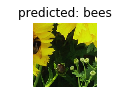

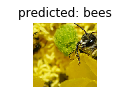

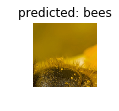

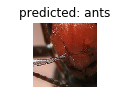

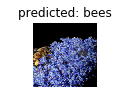

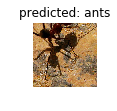

In [10]:
visualize_model(model_ft)

In [12]:
from PIL import Image
import os
from torchvision import transforms
imsize = 256
loader = transforms.Compose([transforms.Resize(imsize),transforms.RandomCrop(224), transforms.ToTensor(),transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])])


def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).cuda()
    image = torch.autograd.Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU
# for x in range(0,50):
#     image = image_loader(f'{data_dir}/train/ants/{files[x]}')
# #     h = vgg16.features(image)
# #     h = h.reshape((1,49*512))
# #     k = vgg16.classifier[:3](h)
# #     k = vgg16(image)
#     n = model_ft(image)
# #     n = n.reshape((1,2))
#     _, preds = torch.max(n.data, 1)
#     print(x,preds) #assumes that you're using GPU


In [13]:
files = os.listdir(f'{data_dir}/train/ants')[:556]

for x in range(0,50):
    image = image_loader(f'{data_dir}/train/ants/{files[x]}')
#     h = vgg16.features(image)
#     h = h.reshape((1,49*512))
#     k = vgg16.classifier[:3](h)
#     k = vgg16(image)
    n = model_ft(image)
#     n = n.reshape((1,2))
    _, preds = torch.max(n.data, 1)
    print(x,preds)

0 tensor([ 0], device='cuda:0')
1 tensor([ 0], device='cuda:0')
2 tensor([ 0], device='cuda:0')
3 tensor([ 0], device='cuda:0')
4 tensor([ 0], device='cuda:0')
5 tensor([ 0], device='cuda:0')
6 tensor([ 0], device='cuda:0')
7 tensor([ 0], device='cuda:0')
8 tensor([ 0], device='cuda:0')
9 tensor([ 0], device='cuda:0')
10 tensor([ 0], device='cuda:0')
11 tensor([ 0], device='cuda:0')
12 tensor([ 0], device='cuda:0')
13 tensor([ 0], device='cuda:0')
14 tensor([ 0], device='cuda:0')
15 tensor([ 0], device='cuda:0')
16 tensor([ 0], device='cuda:0')
17 tensor([ 0], device='cuda:0')
18 tensor([ 0], device='cuda:0')
19 tensor([ 0], device='cuda:0')
20 tensor([ 0], device='cuda:0')
21 tensor([ 0], device='cuda:0')
22 tensor([ 0], device='cuda:0')
23 tensor([ 0], device='cuda:0')
24 tensor([ 0], device='cuda:0')
25 tensor([ 0], device='cuda:0')
26 tensor([ 0], device='cuda:0')
27 tensor([ 0], device='cuda:0')
28 tensor([ 0], device='cuda:0')
29 tensor([ 0], device='cuda:0')
30 tensor([ 0], devi

In [14]:
files = os.listdir(f'{data_dir}/train/bees')[:556]

for x in range(0,50):
    image = image_loader(f'{data_dir}/train/bees/{files[x]}')
#     h = vgg16.features(image)
#     h = h.reshape((1,49*512))
#     k = vgg16.classifier[:3](h)
#     k = vgg16(image)
    n = model_ft(image)
#     n = n.reshape((1,2))
    _, preds = torch.max(n.data, 1)
    print(x,preds)

0 tensor([ 1], device='cuda:0')
1 tensor([ 1], device='cuda:0')
2 tensor([ 1], device='cuda:0')
3 tensor([ 1], device='cuda:0')
4 tensor([ 1], device='cuda:0')
5 tensor([ 1], device='cuda:0')
6 tensor([ 1], device='cuda:0')
7 tensor([ 1], device='cuda:0')
8 tensor([ 1], device='cuda:0')
9 tensor([ 1], device='cuda:0')
10 tensor([ 1], device='cuda:0')
11 tensor([ 1], device='cuda:0')
12 tensor([ 1], device='cuda:0')
13 tensor([ 1], device='cuda:0')
14 tensor([ 1], device='cuda:0')
15 tensor([ 1], device='cuda:0')
16 tensor([ 1], device='cuda:0')
17 tensor([ 1], device='cuda:0')
18 tensor([ 1], device='cuda:0')
19 tensor([ 1], device='cuda:0')
20 tensor([ 1], device='cuda:0')
21 tensor([ 1], device='cuda:0')
22 tensor([ 1], device='cuda:0')
23 tensor([ 1], device='cuda:0')
24 tensor([ 1], device='cuda:0')
25 tensor([ 1], device='cuda:0')
26 tensor([ 1], device='cuda:0')
27 tensor([ 1], device='cuda:0')
28 tensor([ 1], device='cuda:0')
29 tensor([ 1], device='cuda:0')
30 tensor([ 1], devi